<a href="https://colab.research.google.com/github/cocogne2/projet6/blob/master/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importation des librairies et montage du drive

In [1]:
import tensorflow as tf
from google.colab import drive 
from lxml import etree
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
drive.mount('/content/gdrive', force_remount=True)
path_to_data = os.path.join('gdrive','My Drive','projet_6')

Mounted at /content/gdrive


Installation de livelossplot.
Cette librairie permet de faire les graphiques pendant l'estimation qui sont inclus dans la présentation

In [2]:
pip install livelossplot

Cropping et resizing des images

In [ ]:
def cpu():
  %matplotlib inline
  path=os.path.join(path_to_data,'Images')
  for folder in os.listdir(path): 
      if os.path.isdir(os.path.join(path,folder)):
          print("folder",folder)
          path2=os.path.join(path,folder)
          race_chien=folder.split("-",1)[1]
          for file in os.listdir(path2):
            file=file.split(".")[0]
            nom_chien=file.split("_")[1]
            print("file:",file)
            tree = etree.parse(os.path.join(path_to_data,'Annotation', folder, file))
            for x in tree.xpath("/annotation/object/bndbox/xmin"):
                x_min=int(x.text)
            for x in tree.xpath("/annotation/object/bndbox/xmax"):
                x_max=int(x.text)
            for y in tree.xpath("/annotation/object/bndbox/ymin"):
                y_min=int(y.text)
            for y in tree.xpath("/annotation/object/bndbox/ymax"):
                y_max=int(y.text)
            
            # Import the image
            
            im = Image.open(os.path.join(path_to_data,'Images', folder, file+".jpg"))
            im=im.crop((x_min,y_min,x_max,y_max))             
            file_save=race_chien+"*"+nom_chien
            file_name = os.path.join(path_to_data,'images_crop',file_save+".jpg")

            width, height = im.size
            if width>height:
              new_width=224
              size_index=new_width/width
              new_height=round(height*size_index)
            if width<=height:
              new_height=224
              size_index=new_height/height
              new_width=round(width*size_index)
            im=im.resize((new_width,new_height),Image.ANTIALIAS)
            new_im = Image.new("RGB", (224,224))
            new_im.paste(im, (round((224-new_width)/2),
                                round((224-new_height)/2)))
            new_im.save(file_name)
        
cpu()

Utilisation du filtre CLAHE comme égaliseur d'images

In [ ]:
import cv2
path=os.path.join(path_to_data,'images_crop')
for file in os.listdir(path): # Reading the image from the present directory
  print(file)
  image = cv2.imread(os.path.join(path, file))
  # The declaration of CLAHE 
  # clipLimit -> Threshold for contrast limiting
  image_bw =  cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(image_bw)
  clahe = cv2.createCLAHE(clipLimit = 2)
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv2.merge(lab_planes)
  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)    
  cv2.imwrite(os.path.join(path_to_data,'images_crop_clahe_2',file), bgr)

Configuration des paramètres principaux du modèle

In [3]:

# Le chemin vers la sauvegarde du réseau
model_savepath    = os.path.join(path_to_data,'cnn_vgg16_model_trained_sans_drop_1000_200_tanh_sgd_batch_25_momentum_0.h5')     

# Les chemins vers les jeu de données
TRAINING_DIR      = os.path.join(path_to_data,'images_crop')
TESTING_DIR       = os.path.join(path_to_data,'test')

IMGSIZE       = 224    # Taille de l'image en input
EPOCH         = 25     # nombre d'epoch 
BATCH_SIZE    = 25     # traitement par batch d'images avant la descente de gradient
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

In [4]:
def list_unique(list_unique):
    """
    Cette fonction prend une liste en entrée et retourne la liste sans doublon
    """
    new_list = [] 
    for i in list_unique : 
        if i not in new_list: 
            new_list.append(i) 
    return new_list

Constitution des jeux de données

In [6]:
# Dataframe de deux colonnes contenant les id des fichiers et leur label
train_files = os.listdir(TRAINING_DIR)
train_labels = []

for file in train_files:
    train_labels.append(file.split("*",1)[0])
labels_sans_doublon=list_unique(train_labels)
df = pd.DataFrame({"id": train_files, "label": train_labels})
X=df["id"]
y=df["label"]
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25,stratify=y, random_state=1 ) # 25% des données dans le jeu de test
df_train =pd.DataFrame({"id": X_train, "label": y_train})
df_valid =pd.DataFrame({"id": X_test,  "label": y_test})

Importation des bibliothèques nécessaires à la création du modèle

In [7]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

Jeu d'entrainement

In [8]:
# Image generator: attention il est préférable de ne pas utiliser d'augmentation de données
# Nous utilisons également un processing spécifique au VGG16 et non pas un rescale 1./255
train_datagen =  \
        ImageDataGenerator(
            preprocessing_function=preprocess_input,
            validation_split=0)

train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='training',
            class_mode='categorical')
train_labels = to_categorical(train_generator.classes)

Found 15435 validated image filenames belonging to 120 classes.


Jeu de validation

In [9]:
valid_datagen =  \
        ImageDataGenerator(
            preprocessing_function=preprocess_input, validation_split=0)
       
valid_generator = \
        valid_datagen.flow_from_dataframe(
            df_valid,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='training',
            class_mode='categorical')

Found 5145 validated image filenames belonging to 120 classes.


VGG16 pre-entrainé sans le classifier final et création des dernières couches fully connected puis compilation

In [ ]:
# Déclaration du modèle VGG16 (sans le top qui est le classifier)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMGSIZE, IMGSIZE, 3))

x = base_model.output
x = Flatten(name="flatten")(x)
#x = Dropout(0.8)(x)
x = Dense(1000,activation="tanh",  name='top-fc1')(x)
x = Dense(200, activation="tanh",name='top-fc2')(x)
#x = Dropout(0.2)(x)

# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(len(labels_sans_doublon),activation='softmax', name='softmax')(x)
# Assemblage du modèle final
net_final = Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False


# compilation du modele
opt = tf.keras.optimizers.SGD()
net_final.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

Fitting et sauvegarde du modèle

In [ ]:
import time
t1=time.time()
from livelossplot.inputs.keras import PlotLossesCallback
if (TRAIN):
    plot_loss_1 = PlotLossesCallback()

    # Création des Callbacks à appeler aprés chaque epoch
    #   pour sauvegarde des résultats
    checkpoint = ModelCheckpoint("model_1.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
    #   pour arrêt prématuré
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
    history = net_final.fit(train_generator, epochs=EPOCH, validation_data=valid_generator,batch_size=BATCH_SIZE,callbacks = [checkpoint, early, plot_loss_1])
    # Sauvegarde du réseau après entrainement
    net_final.save(model_savepath)    
t2=time.time()
print("temps en min: {}".format((t2-t1)/60))    

Importation du modèle sauvegardé

In [10]:
from tensorflow import keras
net_final = keras.models.load_model(model_savepath)
print(net_final.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Evaluation du modèle

In [11]:
(eval_loss, eval_accuracy) = net_final.evaluate(valid_generator, batch_size=BATCH_SIZE)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

206/206 [==============================] - 2553s 12s/step - loss: 0.8199 - accuracy: 0.7633
[INFO] accuracy: 76.33%
[INFO] Loss: 0.8199097514152527


Création des données servant à tester le modèle

In [11]:
class_dict=train_generator.class_indices
labels= train_generator.labels
#on intervertit le dictionnaire
new_dict={}
for key,value in class_dict.items():
        new_dict[value]=key 
#sauvegarde du dictionnaire pour le programme
#import pickle
#with open("dictionnaire.pkl", "wb") as tf:
#    pickle.dump(new_dict,tf)

valid2_generator = \
        valid_datagen.flow_from_dataframe(
            df_valid,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            shuffle=False,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='training',
            class_mode='categorical')
true_labels=valid2_generator.labels

Found 5145 validated image filenames belonging to 120 classes.


Rapport de classification et confusion matrix

Classification Report
                                precision    recall  f1-score   support

                  Afghan_hound       0.94      0.85      0.89        60
           African_hunting_dog       0.85      0.98      0.91        42
                      Airedale       0.84      0.84      0.84        51
American_Staffordshire_terrier       0.57      0.49      0.53        41
                   Appenzeller       0.50      0.45      0.47        38
            Australian_terrier       0.65      0.67      0.66        49
            Bedlington_terrier       0.81      0.98      0.89        45
          Bernese_mountain_dog       0.77      0.98      0.86        54
              Blenheim_spaniel       0.90      0.94      0.92        47
                 Border_collie       0.59      0.73      0.65        37
                Border_terrier       0.80      0.91      0.85        43
                   Boston_bull       0.75      0.89      0.81        46
          Bouvier_des_Flandres       0.65

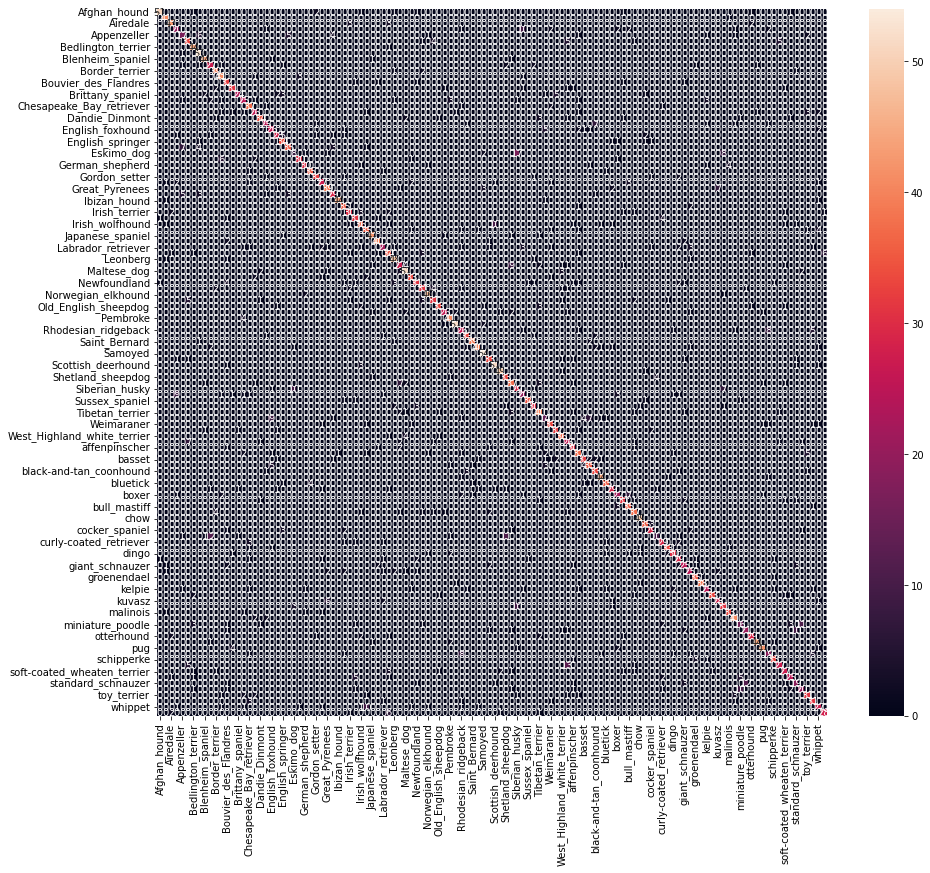

In [12]:
from sklearn.metrics import classification_report
def class_report(model,valid_dataset,valid_labels,dog_race_dict):
    '''
    Computes and displays classification reports.
    '''
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    print('Classification Report')
    a=classification_report(valid_labels, valid_labels_pred, target_names=dog_race_dict.keys())
    print(a)
    return a
import seaborn as sn
from sklearn.metrics import confusion_matrix
def conf_matr(model,valid_dataset,valid_labels,dog_race_dict):
    '''
    Computes and plots the confusion matrix
    '''
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    array = confusion_matrix(valid_labels, valid_labels_pred)
    df_cm = pd.DataFrame(array, index = [i for i in dog_race_dict.keys()],
                      columns = [i for i in dog_race_dict.keys()])

    plt.figure(figsize = (15,13)).patch.set_facecolor('w')
    sn.heatmap(df_cm, annot=True)
    return df_cm
df_cm=conf_matr(net_final,valid2_generator,true_labels,dog_race_dict=class_dict)
#df_cm.to_csv(os.path.join(path_to_data,'confusion_matrix_1000_200_batch_25.csv'),index = True, header=True)
class_report=class_report(net_final,valid2_generator,true_labels,dog_race_dict=class_dict)
#with open(os.path.join(path_to_data,'class_report_1000_200_batch_25.txt'), "w") as text_file:
#    text_file.write(class_report)




Prédiction de quelques images téléchargées sur internet

In [15]:
test_files = os.listdir(TESTING_DIR)
df_test = pd.DataFrame({"id": test_files, 'label': 'nan'})
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = \
    test_datagen.flow_from_dataframe(
        df_test, 
        TESTING_DIR, 
        x_col='id',
        y_col=None, 
        target_size=(IMGSIZE, IMGSIZE), 
        class_mode=None, 
        seed=42,
        batch_size=1, 
        shuffle=False
    )
pred = net_final.predict(test_generator, verbose=0)
pred_labels = np.argmax(pred, axis=1)
true_labels=test_generator.filenames
pred_classe=[]
x2=0
while x2<test_generator.n:
  pred_classe.append(new_dict[pred_labels[x2]])
  x2=x2+1
print(pred_classe)
print(true_labels)

Found 18 validated image filenames.
['Chihuahua', 'Chihuahua', 'Weimaraner', 'dingo', 'affenpinscher', 'black-and-tan_coonhound', 'papillon', 'affenpinscher', 'Airedale', 'golden_retriever', 'Irish_wolfhound', 'golden_retriever', 'cairn', 'Norwich_terrier', 'Rhodesian_ridgeback', 'Scottish_deerhound', 'vizsla', 'Weimaraner']
['2chihuahua4.jpg', '2chichuahua3jpg.jpg', '2weimarener2.jpg', '2chihuahua.jpg', '2affenpisherjpg.jpg', '2blackandtan_coonhound.jpg', '2chihuahua2.jpg', '2affenpisher.jpg', '2airedale.jpg', '2golden retriever.jpg', '2irish-wolfhound.jpg', '2golden retriever2.jpg', '2norwich_terrier.jpg', '2norwich_terrier2.jpg', '2Redbone_Coonhound_.jpg', '2scottish deerhound.jpg', '2Redbone-coonhound-detail.jpg', '2weimaraner.jpg']
